# 모델은 왜 그렇게 예측하였을까? SHAP

## 1.환경준비

### 1) 라이브러리 설치 및 로딩

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.8 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
tf.compat.v1.disable_v2_behavior() # shap 그래프가 tf1 버전을 지원합니다. tf2는 비활성화.

import shap

Instructions for updating:
non-resource variables are not supported in the long term


### 2) 데이터 로딩

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/boston.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


* 변수 설명
    * crim : 범죄율
    * zn : 대저택 비율
    * indus : 상업지역 비율
    * chas : 찰스 강변 여부
    * nox : 일산화질소 농도(공기오염도)
    * rm : 평균 주택당 방 수
    * age : 30년 이상된 주택 비율
    * dis : 주요 업무 지역 접근성 지수
    * rad : 고속도로 접근성 지수
    * tax  1만 달러당 재산세
    * ptratio : 교사1명당 학생수
    * lstat : 하위계층 비율
    * black : 흑인비율(원래 숫자를 변형한 것임)
    * mdev : 타운별 집값 중위수(단위 : 1000달러)

### 3) 필요한 함수 

In [4]:
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

## 2.데이터 준비

### 1)데이터분할

In [117]:
target = 'medv'
x = data.drop(target, axis=1)
y = data[target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 10)

### 2)스케일링
* DL 모델과 SVM 모델에 사용

In [118]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

# x_train_s = pd.DataFrame(x_train_s, columns = list(x_train))
# x_val_s = pd.DataFrame(x_val_s, columns = list(x_val))

## 3.모델링 및 해석

* RandomForest


### 1) 학습

In [119]:
model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

RandomForestRegressor()

In [166]:
model2 = RandomForestRegressor()
model2.fit(x_train, y_train)

RandomForestRegressor()

### 2) 해석

#### ① Shapley Value 만들기

In [120]:
# SHAP 값으로 모델의 예측 설명하기
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(x_train)

In [167]:
explainer2 = shap.TreeExplainer(model2)
shap_values2 = explainer1.shap_values(x_train)

In [121]:
x_train.shape, shap_values1.shape

((404, 13), (404, 13))

In [122]:
x_train[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
50,0.08873,21.0,5.64,0,0.439,5.963,45.7,6.8147,4,243,16.8,395.56,13.45
367,13.52220,0.0,18.10,0,0.631,3.863,100.0,1.5106,24,666,20.2,131.42,13.33


In [123]:
pd.DataFrame(shap_values1, columns = list(x))[:2]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.327325,-0.003980,-0.115394,-0.007199,0.292031,-2.247912,0.207206,-0.450616,-0.006568,0.246191,0.270883,0.125965,-0.469490
1,-0.122281,0.000147,0.029831,0.001169,0.236204,-1.583423,-0.185306,0.188903,0.036744,-0.103526,-0.156045,-0.056254,0.206281


#### ② 특정 데이터에 대한 설명

In [124]:
x_train.iloc[0:1,:]

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
50,0.08873,21.0,5.64,0,0.439,5.963,45.7,6.8147,4,243,16.8,395.56,13.45


* 예측값

In [125]:
# 예측하기 위해서는 입력데이터(x)가 2차원이어야 합니다.
pred = model1.predict(x_train.iloc[:,:])
pred

array([20.015, 20.339, 13.779, 21.073, 21.512, 14.286, 24.593, 18.672,
       12.289, 21.685, 23.525, 25.289, 19.61 , 11.001, 18.99 , 18.274,
       16.041, 21.02 , 46.191, 33.283, 21.539, 14.101, 16.81 , 23.353,
       11.163, 22.336, 22.918, 33.099, 28.963,  8.185, 32.058, 31.171,
       16.099, 24.186, 25.419, 33.806,  9.503,  8.618, 27.396, 10.403,
       15.096, 17.001,  9.49 , 15.743, 41.438, 24.147, 21.052, 19.796,
       12.813, 21.31 , 40.54 , 19.286, 12.549, 18.415, 23.668, 10.01 ,
       15.181, 26.27 , 10.451, 13.554, 17.767, 15.495, 28.763, 20.473,
       23.776, 14.299, 20.674,  9.75 , 24.225, 18.831, 20.001, 44.809,
       25.365, 14.98 , 10.15 , 32.308, 19.207, 16.445, 20.586, 21.372,
       23.291, 19.209,  7.712, 32.101, 21.975, 16.942, 21.914, 21.681,
       22.779, 20.453, 29.368, 33.852, 20.826, 26.111, 10.84 , 22.592,
       23.15 , 33.244, 26.504, 32.124, 22.097, 18.146, 17.297, 22.364,
       34.803, 23.058, 34.09 , 18.755, 21.525, 27.377, 29.959, 34.652,
      

In [175]:
pred3 = model1[0].predict(x_train.iloc[:,:])

In [174]:
model1[0].fit(x_train, y_train)

DecisionTreeRegressor(max_features='auto', random_state=1117453398)

In [168]:
pred2 = model2.predict(x_train.iloc[:,:])


* y_train의 평균 ==> train의 예측값 전체 평균

In [126]:
pred.mean()

21.85261138613861

In [169]:
pred2.mean()

21.836903465346534

In [177]:
pred3.mean()

21.84183168316832

* 예측값과 train의 예측값 전체 평균의 차

In [127]:
pred[0] - pred.mean()

-1.8376113861385868

In [170]:
pred[0] - pred2.mean()

-1.8219034653465123

In [176]:
pred[0] - pred3.mean()

-1.8268316831682974

In [171]:
explainer2.expected_value

array([21.91121535])

In [128]:
print(pred)

[20.015 20.339 13.779 21.073 21.512 14.286 24.593 18.672 12.289 21.685
 23.525 25.289 19.61  11.001 18.99  18.274 16.041 21.02  46.191 33.283
 21.539 14.101 16.81  23.353 11.163 22.336 22.918 33.099 28.963  8.185
 32.058 31.171 16.099 24.186 25.419 33.806  9.503  8.618 27.396 10.403
 15.096 17.001  9.49  15.743 41.438 24.147 21.052 19.796 12.813 21.31
 40.54  19.286 12.549 18.415 23.668 10.01  15.181 26.27  10.451 13.554
 17.767 15.495 28.763 20.473 23.776 14.299 20.674  9.75  24.225 18.831
 20.001 44.809 25.365 14.98  10.15  32.308 19.207 16.445 20.586 21.372
 23.291 19.209  7.712 32.101 21.975 16.942 21.914 21.681 22.779 20.453
 29.368 33.852 20.826 26.111 10.84  22.592 23.15  33.244 26.504 32.124
 22.097 18.146 17.297 22.364 34.803 23.058 34.09  18.755 21.525 27.377
 29.959 34.652 20.71  17.729 19.711 35.419 19.807 24.913 14.585 14.089
 19.352 11.748 19.13  24.129 13.855 14.635 30.545 21.334 23.695 49.298
 14.393 20.319 20.361 18.918 48.076 21.796 26.161 20.135 13.227 19.809
 18.524

In [129]:
print(pred.mean())

21.85261138613861


* Shapley Value

In [130]:
pd.DataFrame(shap_values1[0:1, :], columns = list(x_train))

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.327325,-0.00398,-0.115394,-0.007199,0.292031,-2.247912,0.207206,-0.450616,-0.006568,0.246191,0.270883,0.125965,-0.46949


* Shapley Value 합 : 소수점 반올림된 값 때문에 약간 차이가 있음(넘어갑시다.^^)

In [131]:
shap_values1[0:1, :].sum()

-1.831556930693059

* 그래프로 그려 봅시다.

In [132]:
# y_train의 평균
explainer1.expected_value

array([21.84655693])

In [133]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[0, :], x_train.iloc[0,:])

* 집값 형성에 대해서, 예측결과가 결정 되는데, 
    * 상승 요인 : 
    * 하락 요인 : 

## 4.실습

* 모델의 전체 중요도로 볼 때, lstat가 집값에 가장 큰 영향을 줍니다.
* lstat와 집값(medv)의 관계를 살펴보면, 강한 음의 상관관계가 있음을 알수 있습니다. 
* 그러나, 이 관계에서 벗어난 데이터들이 존재합니다. 이들에 대해서 집값을 예측하는데 영향을 주는 요인을 각각 찾아 설명해 봅시다.

### 1) 모델의 변수 중요도 

### 2) 전체 흐름에서 벗어나 보이는 값들 분석하기

* 아래 그래프를 보면 index 371, 266, 505, 214 데이터가 전체 흐름과 다른 집값을 나태내고 있습니다. 
* 이 값들에 대해서 shapley value를 확인하고 그래프를 통해 이유를 설명해 봅시다.

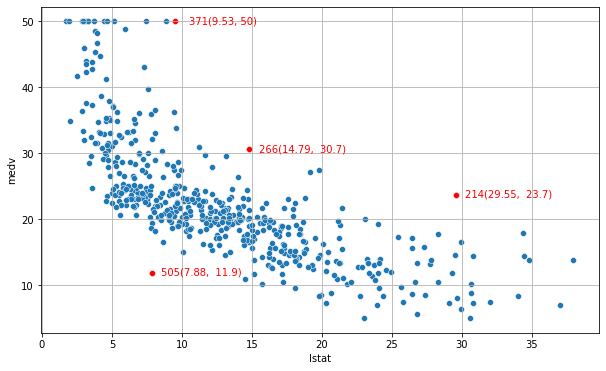

In [134]:
plt.figure(figsize = (10,6))
sns.scatterplot(x='lstat', y = 'medv', data = data)

sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[371]], color = 'r')
plt.text(10.5, 49.6, '371(9.53, 50)', color = 'r')
sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[266]], color = 'r')
plt.text(15.5, 30.2, '266(14.79,  30.7)', color = 'r')
sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[505]], color = 'r')
plt.text(8.5, 11.5, '505(7.88,  11.9)', color = 'r')
sns.scatterplot(x='lstat', y = 'medv', data = data.iloc[[214]], color = 'r')
plt.text(30.2, 23.3, '214(29.55,  23.7)', color = 'r')

plt.grid()
plt.show()

In [135]:
# SHAP 값으로 모델의 예측 설명하기
shap_values1 = explainer1.shap_values(x)

In [136]:
x

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48


In [137]:
explainer1 = shap.TreeExplainer(model1)
shap_values1 = explainer1.shap_values(x)

In [138]:
pred1 = model1.predict(x)

* index = 371

In [139]:
pred1[371]-pred1.mean()

17.52742490118577

In [140]:
shap_values1[371]

array([ 2.66419819e-01, -4.86703163e-03, -1.28028367e-02, -6.62621994e-03,
        2.20915675e-01, -3.51046598e-01, -1.07471389e-01,  1.25349597e+01,
        1.82875338e-02, -1.60370909e-01, -2.42566513e-01,  1.12792894e-01,
        5.89981897e+00])

In [141]:
shap_values1.shape

(506, 13)

In [142]:
pd.DataFrame(shap_values1[371:372, :], columns = list(x))

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.26642,-0.004867,-0.012803,-0.006626,0.220916,-0.351047,-0.107471,12.53496,0.018288,-0.160371,-0.242567,0.112793,5.899819


In [164]:
shap_values1[371:372, :]

array([[ 2.89355135e-01, -1.18453020e-02,  1.98236646e-02,
        -2.02384702e-02,  3.36944778e-01, -2.33799874e+00,
         2.63456915e-03,  2.99721549e-02,  3.10826177e-02,
        -1.71776629e-01,  1.70751155e-01,  3.45611000e-02,
         3.92917704e+00]])

In [165]:
shap_values1

array([[ 3.27325331e-01, -3.98011936e-03, -1.15394400e-01, ...,
         2.70883477e-01,  1.25964781e-01, -4.69489547e-01],
       [-1.22281383e-01,  1.47246985e-04,  2.98305415e-02, ...,
        -1.56045107e-01, -5.62543642e-02,  2.06280742e-01],
       [-6.60069731e-02, -1.14863985e-03, -8.26212942e-02, ...,
        -6.39822899e-01, -1.46180399e-01, -5.69846942e+00],
       ...,
       [ 2.19794980e-01,  6.15919148e-03,  5.75143790e-02, ...,
        -2.05878920e-01, -8.22258004e-02, -5.43339635e-02],
       [ 7.97288752e-01,  1.88687959e-03,  5.88334143e-03, ...,
         3.30376380e-02,  2.12748032e-01, -1.71042710e+00],
       [ 4.04211923e-01, -1.52929217e-02,  1.08491810e-01, ...,
         4.89555067e-01,  1.90683820e-01,  4.86731991e-01]])

In [143]:
shap_values1[371].sum()

18.167443069306977

In [144]:
explainer1.expected_value

array([21.84655693])

In [145]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[371, :], x.iloc[371, :])

* index = 266

In [146]:
pred1[266]-pred1.mean()

6.881424901185756

In [147]:
pd.DataFrame(shap_values1[266:267, :], columns = list(x))

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.236769,-0.024195,0.260263,-0.006158,0.014842,7.518985,-0.022832,0.187014,0.043661,0.251953,0.481699,0.230336,-1.650895


In [148]:
shap_values1[266].sum()

7.521443069306948

In [149]:
explainer1.expected_value

array([21.84655693])

In [150]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[266, :], x.iloc[266, :])

* index = 505

In [151]:
shap_values1.shape

(506, 13)

In [152]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[505, :], x.iloc[505, :])

* index = 214

In [153]:
shap.initjs() # javascript 시각화 라이브러리 --> colab에서는 모든 셀에 포함시켜야 함.

# force_plot(전체평균, shapley_values, input)
shap.force_plot(explainer1.expected_value, shap_values1[214, :], x.iloc[214, :])

In [157]:
model1.feature_importances_

array([0.03301648, 0.00113841, 0.00582824, 0.00095448, 0.02606625,
       0.32837131, 0.01398953, 0.05712439, 0.00362328, 0.01044197,
       0.01470042, 0.01728416, 0.48746109])

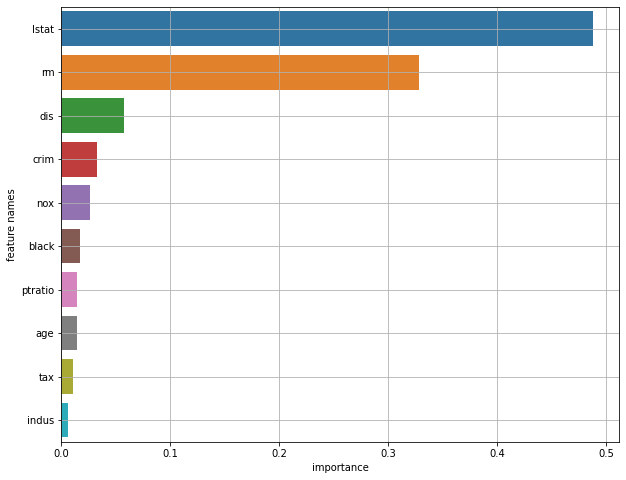

In [158]:
result = plot_feature_importance(model1.feature_importances_, list(x), 10)

## 5.추가 분석

### 1) 데이터 전체를 한눈에

#### ① 전체 변수에 대한 shap value 시각화
* 각 변수별 shapley value 분포를 한눈에 보여줍니다.
* 색깔은 해당 변수의 값의 크기를 나타냅니다.

In [159]:
shap_values1 = explainer1.shap_values(x_train)

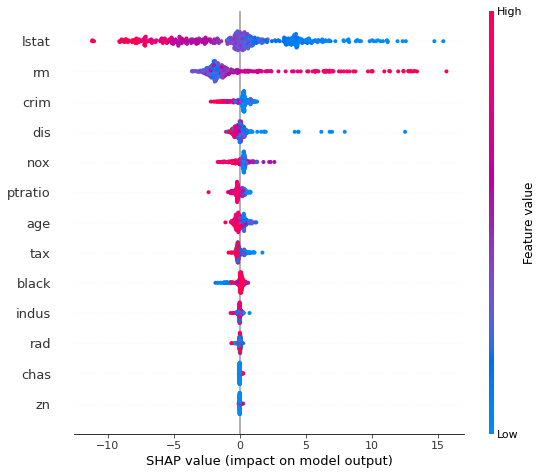

In [160]:
shap.summary_plot(shap_values1, x_train)

#### ② 특정 관점으로 Data point이 Shap Value 정렬

In [161]:
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, x_train)

#### ③ 특정 변수 값과 변수의 shap value 간의 관계

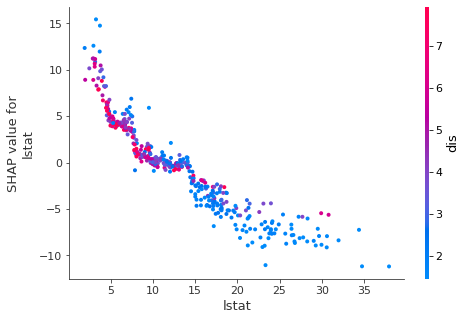

In [162]:
shap.dependence_plot('lstat', shap_values1, x_train)

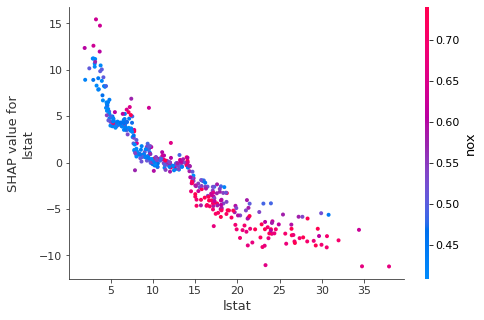

In [163]:
shap.dependence_plot('lstat', shap_values1, x_train, interaction_index = 'nox')

-----------
아래 내용은 시간이 많이 걸리기에 **참조 자료** 로 보시면 좋겠습니다.^^

### 2) KernelExplainer

* SVM에 대한 shapley value 계산은 엄청 오래 걸립니다.
* 그래서 데이터를 줄여서 수행합니다.

#### ① SVM 모델링

In [ ]:
model2 = SVR()
model2.fit(x_train_s, y_train)

#### ② Shap Value 만들기
* shap.KernelExplainer(모델.**predict**, x)
    * TreeExplainer는 그냥 모델을 넣었지만, KernelExpaliner는 모델.**predict**로 넣어야 합니다.
* 데이터를 줄여서 10건만 수행합니다.

In [ ]:
explainer2 = shap.KernelExplainer(model2.predict, x_train_s)

# 10건만 줄여서 수행합니다. 
shap_values2 = explainer2.shap_values(x_train_s[:10])

In [ ]:
shap_values2

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2, x_train_s[:10])

In [ ]:
shap.initjs()
shap.force_plot(explainer2.expected_value, shap_values2[0], x_train.iloc[0])

### 3) DeepExplainer

#### ① DL 모델링

In [ ]:
# 간단한 DL 모델을 생성합니다.
nfeatures = x_train.shape[1]

clear_session()

model3 = Sequential([Dense(4, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(1)])

model3.compile(optimizer=Adam(lr=0.1), loss='mse')

history = model3.fit(x_train_s, y_train, 
                     epochs = 100, batch_size = 64,
                    validation_split=0.2).history

#### ② Shap Value 만들기

* DeepExplainer로 부터 shap_values를 추출하면
    * **리스트 안에 np.array로 값이 저장**됩니다.(아니..왜...)
    * 그래서 이를 사용하려면 값을 뽑아내서(리스트[0])로 사용해야 합니다.

In [ ]:
explainer = shap.DeepExplainer(model3, x_train_s)
shap_values = explainer.shap_values(x_train_s)

In [ ]:
shap_values

In [ ]:
# 리스트에서 값을 빼내기
shap_values = shap_values[0]

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_train.iloc[0])

In [ ]:
shap.summary_plot(shap_values, x_train)